In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import matplotlib
matplotlib.use('agg')

In [3]:
import matplotlib.pyplot as plt
from collections import namedtuple

import data
import panel as pn
import numpy as np
import pandas as pd
pn.extension()
# plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

In [4]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [5]:
 
    
# CSS style for the bordered class
css = """
.bordered {
    border: 2px solid black;
    padding: 10px;
    border-radius: 5px;
}
"""

pn.extension(raw_css=[css])

In [6]:
performance_df = data.get_performace_df()
summary_df = data.get_summary_df()
model_ids, df = data.get_model_df()

In [7]:
current_active_tab = 0   
selected_models = []
alert_placeholder = pn.Column()
info_max_height = 200
plot_height = 400

In [64]:
# sidebar

# Form Functions

In [51]:
def model_estimation(new_model_id, new_features):
    # Here, you can add the logic to compile and run the model estimation using the new_features.
    # For the sake of this example, we'll just mock some data updates:

    # Update performance_df
    performance_df.loc[new_model_id] = [
        np.random.rand(),
        np.random.rand(),
        np.random.rand() * 20,
        np.random.rand() * 20,
        np.random.rand() * 15,
        np.random.rand() * 15,
        np.random.rand() * 15,
        np.random.rand() * 15
    ]

    # Update summary_df
    for feature in new_features:
        coefficient = np.random.rand()
        p_value = np.random.rand()
        vif = np.random.rand() * 10
        summary_df.loc[len(summary_df)] = [new_model_id, feature, coefficient, p_value, vif]

    # Update model_ids and df
 
    model_ids[:] = performance_df.index.values.tolist()
    dates = pd.date_range("2021-01-01", periods=12, freq='M')
    categories = ['In-Sample', 'Out-of-Sample']
    multi_index = pd.MultiIndex.from_product([categories, dates], names=['Category', 'Date'])
    
    # Add the new model to df (assuming the same structure as the existing ones)
    df[new_model_id] = np.random.rand(len(multi_index))


def update_current_features(event=None):
    model_id = model_id_select.value
    current_features = ", ".join(
        summary_df[summary_df['Model ID'] == model_id]['Variable'].loc[:].values)
    current_features_display.object = f"**Current Model ID:** {model_id}\n\n**Current Features:**\n\n{current_features}"

def preview_changes(event):
    model_id = model_id_select.value
    current_features = set(summary_df[summary_df['Model ID'] == model_id]['Variable'].loc[:].values.tolist())
    features_to_add = {f.strip() for f in add_features_input.value.split(",") if f.strip()}
    features_to_remove = {f.strip() for f in remove_features_input.value.split(",") if f.strip()}
    updated_features = (current_features - features_to_remove) | features_to_add
    count = 1
    while True:
        new_model_name = model_id + f"_{count}"
        if new_model_name in model_ids:
            count += 1
            continue
        else:
            break
    preview_output.visible = True     
    preview_output.object = f"**Create New Model {new_model_name} with Features:**\n\nFeatures: {', '.join(updated_features)}"

    
def enable_form_fields(event=None):
    # Here you can add code to enable all fields of the form
     
    model_id_select.value = model_selector.value
    add_features_input.value = ""
    remove_features_input.value = ""
    add_features_input.disabled = False
    remove_features_input.disabled = False
    preview_output.visible = False
    current_features_display.visible = True
    model_selector.disabled = True
    model_selector.scroll_index =  model_id_select.value
    formsidebar.visible = True

def clear_and_disable(event=None):
    # Here you can add code to enable all fields of the form
    return_value = model_id_select.value
    model_id_select.value = ""
    add_features_input.value = ""
    remove_features_input.value = ""
    add_features_input.disabled = True
    remove_features_input.disabled = True
    current_features_display.visible = False
    preview_output.visible = False
    model_selector.disabled = False
    model_selector.value =  return_value
    formsidebar.visible = False

def add_func(event):
    enable_form_fields()
    update_current_features()

    
def form_add_basket(model_id):
    current_selection = model_id
    if current_selection not in selected_models:
        selected_models.append(current_selection)
        # Update the basket_display with the new selection
        basket_display.value = '\n'.join(selected_models)

        
def cancel_func(event):
    clear_and_disable()

def ok_func(event):
    # Logic for running the model based on the user's edits
    model_id = model_id_select.value
    current_features = set(summary_df [summary_df['Model ID'] == model_id]['Variable'].loc[:].values.tolist())
    
    # Parse features to add and remove
    features_to_add = {f.strip() for f in add_features_input.value.split(",") if f.strip()}
    features_to_remove = {f.strip() for f in remove_features_input.value.split(",") if f.strip()}
    
    
    remaining_features = current_features - features_to_remove
    no_features_removed = len(remaining_features)==len(current_features)
    
 
    # Update the feature set
    updated_features = (remaining_features) | features_to_add
    
    count=1
    while True:        
        new_model_name = model_id + f"_{count}"
        if new_model_name in model_ids:
            count += 1 
            continue
        else:
            break 
    
    if no_features_removed and len(features_to_add)==0:
        preview_output.object = f"**Model Changes {new_model_name}:**\n\nFeatures:{', '.join(updated_features)} - No Changes!"
        return 
    
    if len(updated_features)==0:
        preview_output.object = f"**Model Changes {new_model_name}:**\n\nFeatures:{', '.join(updated_features)} - No Variables!"
        return 
 
    model_estimation(new_model_name, updated_features)
    form_add_basket(new_model_name)
    
    # The only reason to create Obj and Event so that I can pass an argument to update_model_selector and not break the code
    Obj = namedtuple('Obj', ['name'])
    Event = namedtuple('Event', ['obj'])
    event = Event(Obj('All'))
    
    update_model_selector(event)
    clear_and_disable()
    

# Sidebar Functions

In [53]:
def update_model_selector(event):
 

    sort_by = sort_selector.value
    sort_ascending = True if sort_by in ['AIC', 'BIC'] else False

    sorted_models = performance_df.sort_values(by=sort_by, ascending=sort_ascending).index.tolist()
    
    par = event.obj.name.split()
   
    if len(par) > 1:
        top = int(par[1])
        sorted_models = sorted_models[:top]
 
     
    model_selector.options = sorted_models
    model_selector.value = sorted_models[0]  # Automatically select the first one

    
    
# Function to update the options of model_selector based on sort_selector
def update_model_options(event = None):
 
    sort_by = event.new if event else sort_selector.value # The new value of sort_selector
    # sort_by = event.new  
    sort_ascending = True if sort_by in ['AIC', 'BIC'] else False  # Ascending for AIC and BIC, else descending
    
    # Sort the models based on the criterion
    sorted_models = performance_df.sort_values(by=sort_by, ascending=sort_ascending).index.tolist()
    
 
    # Update the model_selector options
    model_selector.options = sorted_models

    # Explicitly set the value of model_selector to trigger an update
    model_selector.value = sorted_models[0]




# Function to add the selected model to the basket
def add_to_basket(event):
    current_selection = model_selector.value
    if current_selection not in selected_models:
        selected_models.append(current_selection)
        # Update the basket_display with the new selection
        basket_display.value = '\n'.join(selected_models)

# Alert Change
def alert_change(event):   
    if current_active_tab != 0:  # if not "Main Content" tab
        return    
    
    model_id = event.new
   
    if model_id in selected_models:         
        selected_button.visible = True
    else:
        selected_button.visible = False

# Function to remove the selected model from the basket
def remove_from_basket(event):
    current_selection = model_selector.value
    if current_selection in selected_models:
        selected_models.remove(current_selection)
        # Update the basket_display after removal
        basket_display.value = '\n'.join(selected_models)
    else:
        # Notify if the model isn't in the basket
        pn.pane.Alert(f'Model {current_selection} isn\'t in the basket!', alert_type="warning")

        
# Function to clear the basket
def clear_basket(event):
    selected_models.clear()
    basket_display.value = ''

# Function to reload your data
def refresh_data(event):  
    update_model_options(event = None)
    
    

# Side bar Components

In [65]:
# Create a dropdown widget
model_selector = pn.widgets.Select(name='Select Model', options=model_ids[:-1], value='101'  , size=10   )


# Create another dropdown for sorting the models
sort_selector = pn.widgets.Select(name='Sort by:', options=['AIC', 'BIC', 'AUC_InS', 'AUC_OutS'], value='AIC', width = 100)


# Call the update function manually to sort the models initially
update_model_options()



# Create buttons to limit the number of models to display
show_top_5_button = pn.widgets.Button(name='Top 5', button_type='primary')
show_top_10_button = pn.widgets.Button(name='Top 10', button_type='primary')
show_top_20_button = pn.widgets.Button(name='Top 20', button_type='primary')
show_all_button = pn.widgets.Button(name='All', button_type='primary')
refresh_button = pn.widgets.Button(name='Refresh', width=100)
selected_button = pn.widgets.Button(name='Selected', button_type='warning', disabled=True, visible=False)

show_top_5_button.on_click(update_model_selector)
show_top_10_button.on_click(update_model_selector)
show_top_20_button.on_click(update_model_selector)
show_all_button.on_click(update_model_selector)
refresh_button.on_click(refresh_data)
    
# spacer
spacer = pn.Spacer(width=50)
spacerVertical = pn.Spacer(height=100)


# Button to add the selected model to the basket
select_button = pn.widgets.Button(name="Select", button_type="primary")
select_button.on_click(add_to_basket)

# Button to remove the selected model from the basket
remove_button = pn.widgets.Button(name="Remove", button_type="danger")
remove_button.on_click(remove_from_basket)

# Button to clear the entire basket
remove_all_button = pn.widgets.Button(name="Remove All", button_type="warning")
remove_all_button.on_click(clear_basket)

# A widget to display the models in the basket
basket_display = pn.widgets.TextAreaInput(name='Selected Models', value='', disabled=True,height=120)

# Watch for changes in sort_selector value
sort_selector.param.watch(update_model_options, 'value') 
model_selector.param.watch(alert_change, 'value')

# Display everything
topsidebar = pn.Column(
    sort_selector,
    pn.Row(show_top_5_button,show_top_10_button,show_top_20_button,show_all_button),
    pn.Row(refresh_button, selected_button),
    model_selector,
    pn.Row(select_button, remove_button, remove_all_button),
    basket_display    
    
) 
 

# Form Component

In [66]:

# Setting up widgets
model_id_select = pn.widgets.TextInput(name='Model ID', value="", disabled=True)

current_features_display = pn.pane.Markdown()

add_features_input = pn.widgets.TextInput(name='Add Features (CSV)', value='', disabled=True)
remove_features_input = pn.widgets.TextInput(name='Remove Features (CSV)', value='', disabled=True)

preview_button = pn.widgets.Button(name='Preview', width=100)
preview_button.on_click(preview_changes)

ok_button = pn.widgets.Button(name='OK', width=100)
ok_button.on_click(ok_func)

cancel_button = pn.widgets.Button(name='Cancel', width=100)
cancel_button.on_click(cancel_func)

add_button = pn.widgets.Button(name='Add Model', button_type='primary', width=100)
add_button.on_click(add_func)

preview_output = pn.pane.Markdown()

# Creating the form layout
form_content = pn.Column(
    model_id_select,
    current_features_display,
    add_features_input,
    remove_features_input,
    preview_button,
    preview_output,
    pn.Row(ok_button, cancel_button),
    
)

formsidebar =  pn.Column(form_content, visible=False) # ,    css_classes=['bordered'], visible=False)


# Sidebar

In [69]:
sidebar = pn.Column(
    topsidebar,
    add_button,
    formsidebar
)
 

# Tab 1 Functions

In [13]:

# Function to show both model summary and performance based on selected model_ids
def show_model_info(model_id):

    if current_active_tab != 0:  # if not "Main Content" tab
        return 
    
    if not model_ids:
        return "No model selected"
    
    summary_info =  summary_df.loc[summary_df['Model ID'] ==model_id] # .drop("Model ID",axis=1)
    performance_info = performance_df.loc[[model_id]].reset_index()
    # return summary_info, performance_info
    return pn.Column(
        
         pn.pane.DataFrame(performance_info, name='Model Performance'),
        spacer,
        pn.pane.DataFrame(summary_info, name='Model Summary')          
       
    )
 
# Function to update the plots
def update_plots(model_id):
    
    if current_active_tab != 0:  # if not "Main Content" tab
        return  # Don't make updates
    
    
    # Create a Panel Row layout to put the In-Sample and Out-of-Sample plots side by side
    plots = pn.Row()
    
    for category in ['In-Sample', 'Out-of-Sample']:
        fig, ax = plt.subplots(figsize=(4, 2.5))
        
        
        
        # Get the data for the selected model and "Actual" based on category
        selected_data = df.loc[category, [model_id, 'Actual']]
        
        # Plot data
        ax.plot(selected_data.index, selected_data['Actual'], label="Actual")
        ax.plot(selected_data.index, selected_data[model_id], label=f"{model_id}", linestyle='--')
        
        # Compute the minimum and maximum values for the 'Actual' data
        min_val = df['Actual'].min() - 0.1 * abs(df['Actual'].min())
        max_val = df['Actual'].max() + 0.1 * abs(df['Actual'].max())
        ax.set_ylim([min_val, max_val])

        ax.set_title(f"{model_id} vs Actual ({category})",  fontsize=9)
        ax.set_xlabel("Date", fontsize=7)
        ax.set_ylabel("Value", fontsize=7)
        ax.legend(loc='upper left', fontsize=7)
        
        # Adjust the font size of the tick labels
        ax.tick_params(axis='x', labelsize=7)
        ax.tick_params(axis='y', labelsize=7)   
        plt.xticks(rotation=45)
        plt.close(fig)
        plots.append(pn.pane.Matplotlib(fig, tight=True))
        
    return plots

# Tab 1 Combponets

In [14]:
view_summary = pn.panel(pn.bind(show_model_info, model_selector) , height=info_max_height, sizing_mode='stretch_width', scroll=True)
view_plots = pn.panel(pn.bind(update_plots, model_selector)) 


# Tab 1

In [15]:
tab1 = pn.Column(view_summary, 
                 spacerVertical,
                 view_plots)

# Tab 2 Functions

In [16]:
 
# Define callback functions to update the summary table and the plots
def update_dashboard(event):
    if current_active_tab != 1:
        return
    # Update summary table
    selected_models = event.new    
    
    performance_df_filtered = performance_df[performance_df.index.isin(selected_models)].reset_index() 
    
    sort_by = event.new if event else sort_selector_tab2.value # The new value of sort_selector
    sort_ascending = False if sort_by in ['AIC', 'BIC'] else True
    summary_table_tab2.object =performance_df_filtered.sort_values(by=sort_selector_tab2.value, ascending=sort_ascending)
 
 
def update_model_sort(event=None):    
    if current_active_tab != 1:
        return
    sort_by = event.new if event else sort_selector_tab2.value # The new value of sort_selector
  
    sort_ascending = True if sort_by in ['AIC', 'BIC'] else False  # Ascending for AIC and BIC, else descending
 
    selected_models = model_selector_tab2.value
     
    performance_df_filtered = performance_df[performance_df.index.isin(selected_models)].reset_index()

    summary_table_tab2.object = performance_df_filtered.sort_values(by=sort_selector_tab2.value, ascending=sort_ascending)
 
    

# Function to update the plots based on models selected in the CrossSelector
def update_plots_tab2(selected_models):
    if current_active_tab != 1:
        return
    
    # Create a Panel Row layout to put the In-Sample and Out-of-Sample plots side by side
    plots = pn.Row()

    for category in ['In-Sample', 'Out-of-Sample']:
        fig, ax = plt.subplots(figsize=(4, 2.5))
        
        # Get the data for the "Actual" values based on category
        actual_data = df.loc[category, 'Actual']
        
        # Plot "Actual" data
        ax.plot(actual_data.index, actual_data, label="Actual")
        
        # Iterate over the selected models and plot each
        for model_id in selected_models:
            model_data = df.loc[category, model_id]
            ax.plot(model_data.index, model_data, label=f"{model_id}", linestyle='--')
        
        # Compute the minimum and maximum values for the 'Actual' data
        min_val = df['Actual'].min() - 0.1 * abs(df['Actual'].min())
        max_val = df['Actual'].max() + 0.1 * abs(df['Actual'].max())
        ax.set_ylim([min_val, max_val])

        ax.set_title(f"Models vs Actual ({category})",  fontsize=9)
        ax.set_xlabel("Date", fontsize=7)
        ax.set_ylabel("Value",  fontsize=7)
        ax.legend(loc='upper left', fontsize=7)
        
        # Adjust the font size of the tick labels
        ax.tick_params(axis='x', labelsize=7)
        ax.tick_params(axis='y', labelsize=7)   
        plt.xticks(rotation=45)
        plt.close(fig)
        plots.append(pn.pane.Matplotlib(fig, tight=True))
        
    return plots


# Tab 2 Components

In [17]:

# Create placeholders for the summary table and the plots
summary_table_tab2 = pn.pane.DataFrame(pd.DataFrame(), name="Summary Table")


# selected_models = ['101','102']
# selected_models =model_ids[:-1]
# Create a cross-selector widget
model_selector_tab2 = pn.widgets.CrossSelector(name='Select Models', options=model_ids[:-1], value=[])
sort_selector_tab2 = pn.widgets.Select(name='Sort by:', options=['AIC', 'BIC', 'AUC_InS', 'AUC_OutS'], value='AIC', width = 100)


# Attach the callback to the value parameter of the CrossSelector
model_selector_tab2.param.watch(update_dashboard, 'value')
sort_selector_tab2.param.watch(update_model_sort, 'value');

# Tab 2

In [18]:

# Combine model_selector and plots in a layout
tab2 = pn.Column(
    sort_selector_tab2,
    pn.Row(model_selector_tab2,summary_table_tab2),    
    pn.bind(update_plots_tab2, model_selector_tab2)
)

# Tempate

In [29]:

# Event callback to update the model_selector when the tab is activated
def update_on_tab_activation(event):
    global current_active_tab
    current_active_tab = event.new
    if event.new == 1:  # If "Dormant Tab" is activated
        model_selector_tab2.options = selected_models
        model_selector.disabled = True
        add_button.disabled = True
    else:  # If any other tab is activated
        model_selector_tab2.options = original_model_list
        model_selector.disabled = False
        add_button.disabled = False
 
 
template = pn.template.BootstrapTemplate(
    title='Model Comparison Dashboard',
    sidebar=sidebar,
) 
 
# Placeholder for the content in the new tab
new_tab_content = pn.pane.Markdown('This tab is currently dormant. Activate to see the content based on model selection.')

# Tabbed layout
tabs = pn.Tabs(('Main Content', tab1), ('Dormant Tab', tab2))

# Store the original model list
original_model_list = model_selector.options
tabs.param.watch(update_on_tab_activation, 'active')


template.main.append(tabs)

# template.show()

In [57]:
class EventTest:
    def __init__(self, new, old):
        self.new = new
        self.old = old
        


Row
    [0] Column
        [0] Column
            [0] Select(name='Sort by:', options=['AIC', 'BIC', ...], value='AIC', width=100)
            [1] Row
                [0] Button(button_type='primary', name='Top 5')
                [1] Button(button_type='primary', name='Top 10')
                [2] Button(button_type='primary', name='Top 20')
                [3] Button(button_type='primary', name='All')
            [2] Row
                [0] Button(name='Refresh', width=100)
                [1] Button(button_type='warning', disabled=True, name='Selected')
            [3] Select(options=['105', '105_3_1', ...], size=10, value='105_3_1')
            [4] Row
                [0] Button(button_type='primary', name='Select')
                [1] Button(button_type='danger', name='Remove')
                [2] Button(button_type='warning', name='Remove All')
            [5] TextAreaInput(disabled=True, height=120, name='Selected Models', value='105_3\n105_3_1')
        [1] Button(button_type='primary', clicks=2, name='Add Model', width=100)
        [2] Column(visible=False)
            [0] Column
                [0] TextInput(disabled=True, name='Model ID')
                [1] Markdown(str, visible=False)
                [2] TextInput(disabled=True, name='Add Features (CSV)', value_input='fsasd')
                [3] TextInput(disabled=True, name='Remove Features (CSV)')
                [4] Button(clicks=2, name='Preview', width=100)
                [5] Markdown(str, visible=False)
                [6] Row
                    [0] Button(clicks=2, name='OK', width=100)
                    [1] Button(name='Cancel', width=100)
    [1] Column
        [0] ParamFunction(function, _pane=Column, defer_load=False, height=200, sizing_mode='stretch_width')
        [1] Spacer(height=100)
        [2] ParamFunction(function, _pane=Row, defer_load=False)
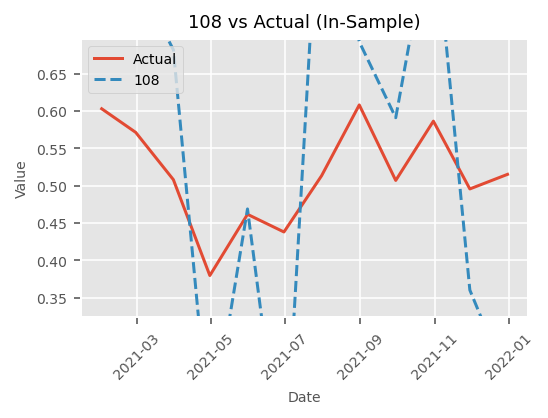
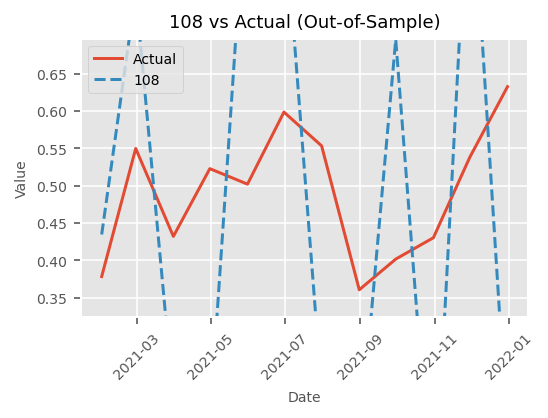

In [73]:
mock_event = EventTest(new=0, old=1)
update_on_tab_activation(mock_event)
pn.Row(
    sidebar,
    tab1, 
    
)

In [71]:
# 
# selected_models= []
selected_models

['105_3', '105_3_1']

Row
    [0] Column
        [0] Select(name='Sort by:', options=['AIC', 'BIC', ...], value='AIC', width=100)
        [1] Row
            [0] CrossSelector(name='Select Models', options=['105_3', '105_3_1', ...], value=['105_3_1', '105_3'])
            [1] DataFrame(DataFrame, name='Summary Table')
        [2] ParamFunction(function, _pane=Row, defer_load=False)
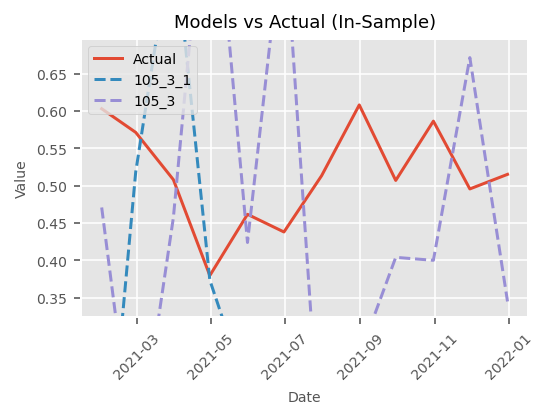
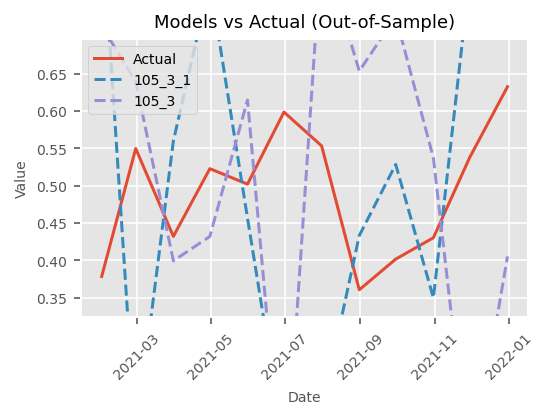

In [74]:

mock_event = EventTest(new=1, old=0)
update_on_tab_activation(mock_event)

pn.Row( 
    tab2, 
    
)

In [27]:
pn.event

AttributeError: module 'panel' has no attribute 'event'